In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


# Inspect Data

See what the data looks like

In [26]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


In [27]:
train_df = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
test_df = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0,60000.000000,60000.0
mean,4.500000,0.0,0.0,0.0,0.0,0.0,0.008817,0.029467,0.037767,0.075933,...,0.015583,0.016450,0.013417,0.022300,0.012217,0.001383,0.003783,0.0,0.002717,0.0
std,2.872305,0.0,0.0,0.0,0.0,0.0,1.474271,2.700491,2.726371,3.993023,...,1.443852,1.958914,1.342572,2.051846,1.730959,0.338846,0.926724,0.0,0.665445,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
50%,4.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,157.000000,255.000000,255.000000,83.000000,227.000000,0.0,163.000000,0.0


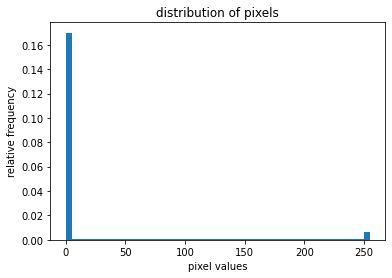

In [29]:
def plot_pixel_dist(dataframe):
    x = dataframe.to_numpy()[:, 1:].reshape(-1)
    plt.hist(x, bins=50, density=True)
    plt.xlabel("pixel values")
    plt.ylabel("relative frequency")
    plt.title("distribution of pixels");
    
plot_pixel_dist(train_df)

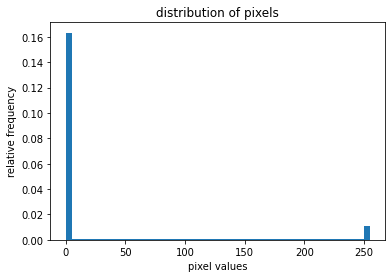

In [30]:
plot_pixel_dist(test_df)

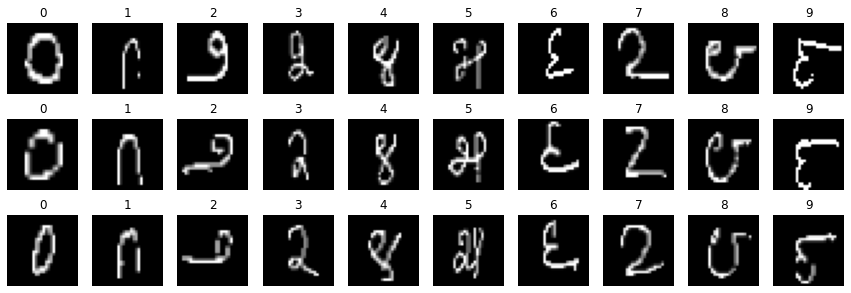

In [31]:
def show_sample(dataframe, row=1):
    figure = plt.figure(figsize=(15, 5))
    
    for r in range(row):
        for i, group in enumerate(train_df.groupby("label")):
            label, df = group
            data = df.to_numpy()[:, 1:]
            sample_idx = torch.randint(len(data), size=(1,)).item()
            x = data[sample_idx]

            figure.add_subplot(row, 10, r * 10 + i + 1)
            plt.title("%d" % label)
            plt.axis("off")
            plt.imshow(x.reshape((28, 28)), cmap="gray")
    
    plt.show()
    
show_sample(train_df, row=3)

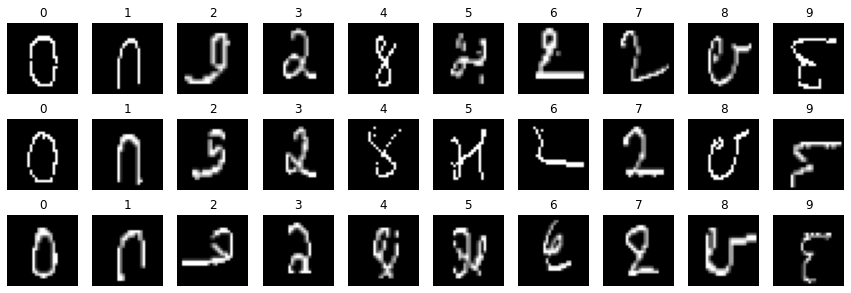

In [32]:
show_sample(test_df, row=3)

# Image Augmentation

Example picture before augmentation

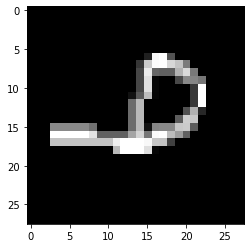

In [33]:
ex_idx = 53482
ex = train_df.to_numpy()[ex_idx, 1:]
ex = torch.tensor(ex).reshape((28, 28, 1)).type(torch.FloatTensor)

plt.imshow(ex, cmap="gray")

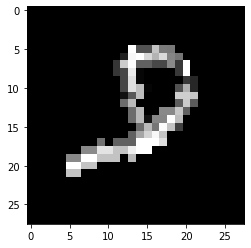

In [77]:
import torchvision.transforms as transforms

img_aug = transforms.Compose([
    lambda x: x.reshape(28, 28),
    transforms.ToPILImage("F"),
    transforms.RandomRotation(degrees=(0, 40)),
#     transforms.RandomResizedCrop((28, 28)),
    transforms.ToTensor(),
    lambda x: x.reshape(28, 28),
])

ex_aug = img_aug(ex)
plt.imshow(ex_aug, cmap="gray")

# Define Dataset and Model

In [118]:
def load_csv(path):
    df = pd.read_csv(path)
    data = df.to_numpy()
    X = data[:, 1:]
    Y = data[:, 0]
    return X, Y

X, Y = load_csv("/kaggle/input/Kannada-MNIST/train.csv")
X.shape, Y.shape

In [116]:
train_x, valid_x, train_y, valid_y = train_test_split(X, Y, test_size = 0.10, stratify=Y, random_state=42) 

Double check if validation set has the even distribution data per each label

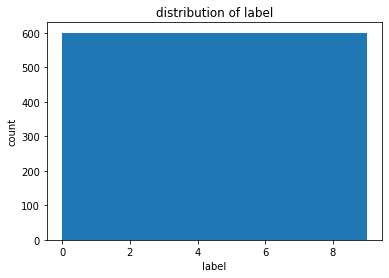

In [121]:
plt.hist(valid_y, bins=10)
plt.xlabel("label")
plt.ylabel("count")
plt.title("distribution of label");

In [61]:
def imgset_to_tensor(x):
    """x - (m, n) matrix (array of np), where m is example size and n is feature size"""
    x = torch.tensor(x).type(torch.FloatTensor)
    x = x.reshape((-1, 28, 28, 1)) / 255
    
    return x

In [126]:
class KannadaDataset(Dataset):
    def __init__(self, X, Y, img_aug=False):        
        self.X = imgset_to_tensor(X)
        self.Y = torch.tensor(Y)
        self.img_aug = img_aug
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        
        if img_aug:
            x = img_aug(x)
        
        return x, self.Y[idx]


train_ds = KannadaDataset(train_x, train_y, img_aug=True)
valid_ds = KannadaDataset(valid_x, valid_y)

In [127]:
test_x, test_y = load_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")    
test_ds = KannadaDataset(test_x, test_y)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # 28 * 28 = 784
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [129]:
# pred: (m, 10), y: (m)
def accuracy(pred, y):
    return (pred.argmax(dim=1) == y).type(torch.float).sum() / y.shape[0]

accuracy(torch.tensor([
        [1, 2, 3],
        [2, 3, 1]
    ]), 
    torch.tensor([2, 0])
)

tensor(0.5000)

In [130]:
def train(dataloader, model, loss_fn, optimizer, verbose=False):
    """run one epoch. return average lost and accuracy of all mini batches"""
    size = len(dataloader.dataset)
    model.train()
    loss_set = []
    acc_set = []
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # forward prop
        pred = model(X)
        loss = loss_fn(pred, y)
        acc = accuracy(pred, y)

        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_set.append(loss.item())
        acc_set.append(acc.item())
   
        if verbose and batch % 400 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}, acc: {acc:>7f}  [{current:>5d}/{size:>5d}]")
    
    return np.mean(loss_set), np.mean(acc_set)   

In [131]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_sum, correct_sum = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss_sum += loss_fn(pred, y).item()
            correct_sum += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    loss = loss_sum / num_batches
    accuracy = correct_sum / size
    
    return loss, accuracy

In [163]:
def training_loop(model, train_dl, valid_dl, test_dl, loss_fn, optimizer, epochs=20):
    metric = pd.DataFrame(columns=["tr_loss",
                                   "tr_acc",
                                   "val_loss",
                                   "val_acc",
                                   "test_loss",
                                   "test_acc"])
    for t in range(epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        
        tr_loss, tr_acc = train(train_dl, model, loss_fn, optimizer, verbose=True)
        val_loss, val_acc = test(valid_dl, model, loss_fn)
        test_loss, test_acc = test(test_dl, model, loss_fn)

        metric = metric.append({
            "tr_loss": tr_loss,
            "tr_acc": tr_acc, 
            "val_loss": val_loss,
            "val_acc": val_acc, 
            "test_loss": test_loss,
            "test_acc": test_acc
        }, ignore_index=True)

        print("\n")
        print(f"train acc: {(100 * tr_acc):>0.1f}% train loss: {tr_loss:>8f}")
        print(f"valid acc: {(100 * val_acc):>0.1f}% valid loss: {val_loss:>8f}")
        print(f"test  acc: {(100 * test_acc):>0.1f}% test  loss: {test_acc:>8f}")
    
    return metric

In [164]:
batch_size = 32
epochs = 20
device = "cpu"

train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds)
test_dl = DataLoader(test_ds)

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = training_loop(model, train_dl, valid_dl, test_dl, loss_fn, optimizer, epochs)


Epoch 1
-------------------------------
loss: 2.304177, acc: 0.125000  [    0/54000]
loss: 0.069609, acc: 0.968750  [12800/54000]
loss: 0.215281, acc: 0.906250  [25600/54000]
loss: 0.184878, acc: 0.937500  [38400/54000]
loss: 0.054330, acc: 0.968750  [51200/54000]


train acc: 93.6% train loss: 0.204354
valid acc: 96.9% valid loss: 0.099872
test  acc: 62.8% test  loss: 0.627930

Epoch 2
-------------------------------
loss: 0.045386, acc: 0.968750  [    0/54000]
loss: 0.008695, acc: 1.000000  [12800/54000]
loss: 0.095539, acc: 0.968750  [25600/54000]
loss: 0.168481, acc: 0.906250  [38400/54000]
loss: 0.037057, acc: 0.968750  [51200/54000]


train acc: 97.4% train loss: 0.088169
valid acc: 97.9% valid loss: 0.070267
test  acc: 65.0% test  loss: 0.649512

Epoch 3
-------------------------------
loss: 0.090594, acc: 0.968750  [    0/54000]
loss: 0.005762, acc: 1.000000  [12800/54000]
loss: 0.110704, acc: 0.937500  [25600/54000]
loss: 0.121430, acc: 0.937500  [38400/54000]
loss: 0.020001,

In [165]:
history

,tr_loss,tr_acc,val_loss,val_acc,test_loss,test_acc
0,0.204354,0.935963,0.099872,0.969167,2.126180,0.627930
1,0.088169,0.973637,0.070267,0.979333,2.203443,0.649512
2,0.068784,0.979969,0.070466,0.981167,1.887825,0.663379


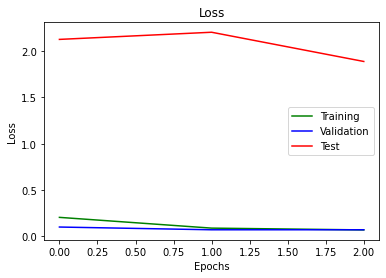

In [168]:
def plot_metric(train, valid, test, label):    
    plt.plot(train, 'g', label='Training')
    plt.plot(valid, 'b', label='Validation')
    plt.plot(test, 'r', label='Test')
    plt.title(label)
    plt.xlabel('Epochs')
    plt.ylabel(label)
    plt.legend()
    plt.show()
    
plot_metric(history.loc[:, "tr_loss"], 
            history.loc[:, "val_loss"], 
            history.loc[:, "test_loss"], "Loss")

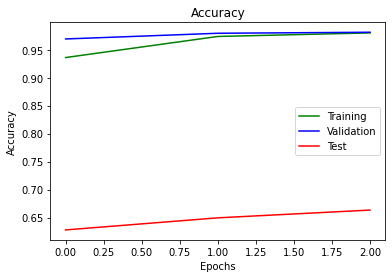

In [169]:
plot_metric(history.loc[:, "tr_acc"], 
            history.loc[:, "val_acc"], 
            history.loc[:, "test_acc"], "Accuracy")

# Manual Test

In [ ]:
model.eval()
ex_idx = torch.randint(len(train_ds), size=(1,)).item()
x, y = train_ds[ex_idx]

with torch.no_grad():
    pred = model(x.reshape((1, 28, 28))).reshape((10)).argmax()
    print(f"actual: {y}, pred: {pred}")
    plt.imshow(x, cmap="gray")

# Run Test Dataset and Create Submission

In [66]:
test_df = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
test_df

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,4996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,4997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,4998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
data = test_df.to_numpy()
data.shape

(5000, 785)

In [72]:
test_x = imgset_to_tensor(data[:, 1:])
test_x.shape

torch.Size([5000, 28, 28, 1])

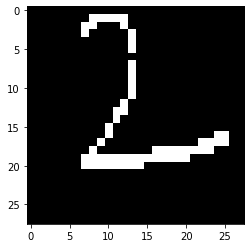

In [73]:
plt.imshow(test_x[5], cmap="gray")

In [74]:
with torch.no_grad():
    pred = model(test_x)
    
pred = torch.argmax(pred, dim=1)
pred.shape

torch.Size([5000])

In [ ]:
res = pd.DataFrame(data={ 
    "id": test_df["id"],
    "label": pred
})
res

In [ ]:
res.to_csv("submission.csv", columns=["id", "label"], index=False)